In [3]:
import os
import sys
sys.path.append('/Users/ericayliu/Bowling Lab/gastruloids_precisionandscaling-main-src/')
import numpy as np
import matplotlib.pyplot as plt
# import cv2
import src.image.imUtils as imu
import src.image.imUtilsJ as imuj
import javabridge as jv
import src.analysis.medialaxis as ma
import src.analysis.pipelines as pip

Could not find Java JRE compatible with x86_64 architecture


In [4]:
import numpy as np

import src.image.imUtils as imu
import src.image.imUtilsJ as imuj

from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
import networkx as nx


def find_longest_edge(l, T):
    '''  '''
    e1 = T[l[0]][l[1]]['weight']
    e2 = T[l[0]][l[2]]['weight']
    e3 = T[l[1]][l[2]]['weight']
    E=[e1,e2,e3]

    # if any(e ==0 for e in E):
    #     return()
    if e2 < e1 > e3:
        return (l[0], l[1])
    elif e1 < e2 > e3:
        return (l[0], l[2])
    elif e1 < e3 > e2:
        return (l[1], l[2])

def path_cost(G, path):
    return sum([G[path[i]][path[i+1]]['weight'] for i in range(len(path)-1)])

def path_sublength(G, path, sublength):

    Ssubpath = 0
    for i in range(len(path)-1):
        Ssubpath = Ssubpath + G[path[i]][path[i+1]]['weight']
        if Ssubpath > sublength:
            return path[i-1]

def orderPoints( C_skel):
    ''' Reorder the coordinates skel of the skeleton '''

    G = kneighbors_graph(C_skel, 2, mode='distance')
    T = nx.from_scipy_sparse_array(G)
    degrees = np.array([val for (node, val) in T.degree()])
    endidx = np.argwhere(degrees == 1).squeeze()

    end_cliques = [i for i in list(nx.find_cliques(T)) if len(i) == 3]
    edge_lengths = [find_longest_edge(i, T) for i in end_cliques]
    T.remove_edges_from(edge_lengths)

    # degrees = np.array([val for (node, val) in T.degree()])
    # endidx = np.argwhere(degrees == 1).squeeze()
    # opt_order = nx.shortest_path(T,source=endidx[0], target=endidx[1])

    paths = [list(nx.dfs_preorder_nodes(T, i)) for i in range(len(C_skel))]
    mindist = np.inf
    minidx = 0

    lenp=[]
    costs=[]
    for i in range(len(C_skel)):
        p = paths[i]           # order of nodes
        lenp.append(len(p))
        ordered = C_skel[p]    # ordered nodes
        # find cost of that order by the sum of euclidean distances between points (i) and (i+1)
        cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
        costs.append(cost)
        if cost < mindist:
            mindist = cost
            minidx = i

    opt_order = paths[minidx]
    C_skel_O = C_skel[opt_order, :]

    return C_skel_O, T



def interpol(x,y):
    ''' '''

    dx = np.sum(np.diff(x))
    dy = np.sum(np.diff(y))

    if dx==0:
        m = 1
        n = 0
        p = -np.mean(x)
    else:
        m = dy/dx
        n = -1
        p = np.mean(y) - m*np.mean(x)

    return [m,n,p]

def interpolateEnds( C_skel, ratio=3, lenMin=2):
    ''' '''

    xSkel, ySkel = C_skel.T
    if len(xSkel)<2*lenMin+1:
        indBeg = np.min([lenMin, len(xSkel)])
        indEnd = np.min([0, np.abs(len(xSkel)- lenMin)])
    else:
        indBeg = np.max( [np.int(np.floor(len(ySkel)*ratio/100)), lenMin])
        indEnd = np.min( [np.int(np.ceil(len(ySkel)*(100-ratio)/100)), len(xSkel)- lenMin])

    xBeg = xSkel[:indBeg]
    yBeg = ySkel[:indBeg]

    xEnd = xSkel[indEnd:]
    yEnd = ySkel[indEnd:]

    fB = interpol(xBeg,yBeg)
    fE = interpol(xEnd,yEnd)

    return fB, fE

def intersect(C_cnt, f, P_skel, no=[]):
    '''  '''
    m,n,p = f

    xCnt,yCnt = C_cnt.T
    finter = lambda x,y: m*x+n*y+p
    res = [ finter(xCnt[i], yCnt[i]) for  i in range(len(xCnt))]
    ind = np.argwhere(np.abs(res)< np.sqrt(2)*4)

    test_cnt = np.c_[xCnt[ind], yCnt[ind]]

    G = radius_neighbors_graph(test_cnt, radius =10)
    T = nx.from_scipy_sparse_array(G)

    end_cliques =[i for i in list(nx.find_cliques(T))]
    # I = np.empty(len(end_cliques), dtype=np.int)

    I =[]
    for i, a in enumerate(end_cliques):
        A = [ ind[a[j]][0] for j in range(len(a))]
        resA = [res[j] for j in A]
        if all(a not in no for a in A) :
            I.append(A[np.argmin(np.abs(resA))])

    m = [ np.sum( (xCnt[a]- P_skel[0] )**2 + (yCnt[a]- P_skel[1] )**2) for a in I]
    intersectI = I[np.argmin(m)]

    return intersectI

def appendMedialAxis( C_skel,  C_endpoint, order = 'after' ):

    xSkel, ySkel = C_skel.T
    if order == 'after':
        ind = -1
    elif order == 'before':
        ind = 0
    mainDir = np.argmax( [ np.abs(xSkel[ind]- C_endpoint[0]), np.abs(ySkel[ind]- C_endpoint[1])] )

    if mainDir == 0:
        xa = np.arange(C_endpoint[0], xSkel[ind], 0.8*np.sign(xSkel[ind]- C_endpoint[0]))
        # , dtype=int)
        ya = np.linspace(C_endpoint[1], ySkel[ind], num= len(xa))
        # , dtype=int)
    elif mainDir == 1:
        ya = np.arange(C_endpoint[1], ySkel[ind], 0.8*np.sign(ySkel[ind]- C_endpoint[1]))
        # , dtype=int)
        xa = np.linspace(C_endpoint[0], xSkel[ind],num= len(ya))
                         # , dtype=int)

    if order == 'after':
        xMA = np.concatenate((xSkel[:-1], np.flip(xa)), axis=0)
        yMA = np.concatenate((ySkel[:-1], np.flip(ya)), axis=0)
    elif order == 'before':
        xMA = np.concatenate((xa, xSkel[1:]), axis=0)
        yMA = np.concatenate((ya, ySkel[1:]), axis=0)

    C_axis = np.c_[xMA,yMA]

    return C_axis


def expand_skel(C_skel, C_cnt):
    '''  '''

    if len(C_skel)>3:
        C_skel, _ = orderPoints(C_skel)
    fb,fe = interpolateEnds(C_skel)

    Ib = intersect(C_cnt, fb, C_skel[0])
    if fb==fe:
        Ie = intersect(C_cnt, fe, C_skel[-1], no=[Ib])
    else:
        Ie = intersect(C_cnt, fe, C_skel[-1])

    C_axis = appendMedialAxis(C_skel, C_cnt[Ib], order='before')

    C_axis = appendMedialAxis(C_axis, C_cnt[Ie], order='after')
    if len(C_axis)>3:
        C_axis, _ = orderPoints(C_axis)
    return C_axis

def expand_skel_return(C_skel, C_cnt, ratio=3, lenMin=2):
    '''  '''

    if len(C_skel)>2:
        C_skel, _ = orderPoints(C_skel)
    fb,fe = interpolateEnds(C_skel, ratio, lenMin)
    Ib = intersect(C_cnt, fb, C_skel[0])
    if fb==fe:
        Ie = intersect(C_cnt, fe, C_skel[-1], no=[Ib])
    else:
        Ie = intersect(C_cnt, fe, C_skel[-1])

    C_axis = appendMedialAxis(C_skel, C_cnt[Ib], order='before')
    C_axis = appendMedialAxis(C_axis, C_cnt[Ie], order='after')
    if len(C_axis)>3:
        C_axis, _ = orderPoints(C_axis)
    return C_axis, Ib, Ie

def get_length(C_axis):

    C_axis, Tma = orderPoints(C_axis)
    return path_cost(Tma, nx.shortest_path(Tma, source = 0, target = np.size(C_axis,0) - 1 ) )

def get_length_return(C_axis):

    C_axis, Tma = orderPoints(C_axis)
    return path_cost(Tma, nx.shortest_path(Tma, source = 0, target = np.size(C_axis,0) - 1 ) ), Tma

def subdivid(Graph, ndiv):

    path = nx.shortest_path(Graph, source= min(Graph.nodes), target= max(Graph.nodes))
    L = path_cost(Graph, path)
    print(L)

    subl = 0
    I_subdivision = [path[0]]
    for j in range(ndiv - 1):
        subl = subl + L / ndiv
        I_subdivision.append(path_sublength(Graph, path, subl))

    I_subdivision.append(path[-1])

    return I_subdivision

def get_volume(mask, image, ndiv= 50):

    from skimage.morphology import medial_axis

    cnt = imu.get_contour(mask, image)
    cnt = np.asarray(cnt[0])
    skel = medial_axis(imuj.snake_to_bw(cnt, image.shape))
    skel = np.argwhere(skel)
    MedialAxis, ie, ib = expand_skel_return(skel, cnt)
    # MedialAxis, ie, ib = expand_skel_return(skel, cnt, ratio=5, lenMin=10)

    Lskel, Tma = get_length_return(MedialAxis)

    xCA, yCA = cnt.T
    xMA, yMA = MedialAxis.T


    ## create and clear the graph of the contour

    Gcnt = kneighbors_graph(cnt, 2, mode='distance')
    Tcnt = nx.from_scipy_sparse_array(Gcnt)
    end_cliques = [i for i in list(nx.find_cliques(Tcnt)) if len(i) == 3]
    edge_lengths = [find_longest_edge(i, Tcnt) for i in end_cliques]
    Tcnt.remove_edges_from(edge_lengths)

    ## Find the two paths along the contour
    # from one end to the other end of the gastruloid midline
    L = []
    P = []
    for path in nx.all_simple_paths(Tcnt, source=ie, target=ib):
        P.append(path)
        L.append(path_cost(Tcnt, path))

    ## Subdivide each side

    for i, l in enumerate(L):

        subl = 0
        I = [P[i][0]]
        for j in range(ndiv - 1):
            subl = subl + l / ndiv
            I.append(path_sublength(Tcnt, P[i], subl))
        I.append(P[i][-1])

        if i == 0:
            A = I
            subX1 = [xCA[k] for k in I]
            subY1 = [yCA[k] for k in I]
        if i == 1:
            B = I
            subX2 = [xCA[k] for k in I]
            subY2 = [yCA[k] for k in I]


    #%% Calculate the radius and heights

    path = list(nx.shortest_path(Tma, source=0, target=len(xMA) - 1))

    f = []
    M = [path[0]]
    h = np.zeros(ndiv)
    radius = np.zeros(ndiv - 1)
    for i in range(1, len(subX1) - 1):
        xxx = [subX1[i], subX2[i]]
        yyy = [subY1[i], subY2[i]]

        m = (yyy[1] - yyy[0]) / (xxx[1] - xxx[0])
        p = yyy[0] - m * xxx[0]
        f.append(np.poly1d([m, p]))
        radius[i - 1] = np.power(np.power((yyy[1] - yyy[0]), 2) + np.power((xxx[1] - xxx[0]), 2), 0.5) / 2

        finter = lambda x, y: y - f[i - 1](x)
        res = finter(xMA, yMA)
        M.append(np.argmin(np.abs(res)))
        path = list(nx.shortest_path(Tma, source=M[i - 1], target=M[i]))
        h[i - 1] = path_cost(Tma, path)

    M.append(len(yMA) - 1)
    path = list(nx.shortest_path(Tma, source=M[-2], target=M[-1]))
    h[-1] = path_cost(Tma, path)

    ## Calculate the volume in pixels ^3

    vol_coneslice = lambda r, R, h: np.pi / 3 * h * (r ** 2 + R ** 2 + r * R)
    # vol_cone = lambda r, h: np.pi * h * r ** 2 / 3
    vol_cap = lambda r, h: np.pi * h * (3 * r ** 2 + h ** 2) / 6

    # first bin:
    V = vol_cap(radius[0], h[0])

    # the middle:
    for i in range(1, ndiv - 2):
        V = V + vol_coneslice(radius[i], radius[i - 1], h[i])

    # last bin:
    V = V+ vol_cap(radius[-1], h[-1])

    ## Return the length of segments 1/4, 2/4, 3/4

    segments_bound = list(zip(  np.vstack((subX1, subY1)), np.vstack((subX2, subY2))))

    L_quart = [2 * radius[i] for i in range(round(ndiv / 4), ndiv, round(ndiv / 4))]
    if L_quart[0]> L_quart[2]:
        L_quart = np.flip(L_quart)


    return MedialAxis, Lskel, segments_bound, L_quart, V

def get_axis_and_length( cnt, image):

    from skimage.morphology import medial_axis

    skel = medial_axis(imuj.snake_to_bw(cnt, image.shape))
    skel = np.argwhere(skel)
    MedialAxis, ie, ib = expand_skel_return(skel, cnt, ratio=5, lenMin=10)
    Lskel, Tma = get_length_return(MedialAxis)

    return MedialAxis, Lskel


def bin_volume(MedialAxis, cnt,  image, ndiv= 50):

    xCA, yCA = cnt.T
    MedialAxis, Tma = orderPoints(MedialAxis)
    xMA, yMA = MedialAxis.T

    mb = np.zeros(len(cnt))
    me = np.zeros(len(cnt))
    Mb = MedialAxis[0]
    Me = MedialAxis[-1]
    for i, C in enumerate(cnt):
        mb[i] = np.sum((C[0] - Mb[0]) ** 2 + (C[1] - Mb[1]) ** 2)
        me[i] = np.sum((C[0] - Me[0]) ** 2 + (C[1] - Me[1]) ** 2)

        ib = np.argmin(mb)
        ie = np.argmin(me)


    ## create and clear the graph of the contour

    Gcnt = kneighbors_graph(cnt, 2, mode='distance')
    Tcnt = nx.from_scipy_sparse_array(Gcnt)
    end_cliques = [i for i in list(nx.find_cliques(Tcnt)) if len(i) == 3]
    edge_lengths = [find_longest_edge(i, Tcnt) for i in end_cliques]
    Tcnt.remove_edges_from(edge_lengths)

    ## Find the two paths along the contour
    # from one end to the other end of the gastruloid midline
    L = []
    P = []
    for path in nx.all_simple_paths(Tcnt, source=ib, target=ie):
        P.append(path)
        L.append(path_cost(Tcnt, path))

    ## Subdivide each side

    for i, l in enumerate(L):

        subl = 0
        I = [P[i][0]]
        for j in range(ndiv - 1):
            subl = subl + l / ndiv
            I.append(path_sublength(Tcnt, P[i], subl))
        I.append(P[i][-1])

        if i == 0:
            A = I
            subX1 = [xCA[k] for k in I]
            subY1 = [yCA[k] for k in I]
        if i == 1:
            B = I
            subX2 = [xCA[k] for k in I]
            subY2 = [yCA[k] for k in I]


    #%% Calculate the radius and heights

    path = list(nx.shortest_path(Tma, source=0, target=len(xMA) - 1))

    f = []
    M = [path[0]]
    h = []
    radius = []
    segments_bound= [list(zip([xCA[ib], xCA[ib]], [yCA[ib], yCA[ib]]))]

    fusionP = np.int(np.round(ndiv/50)) # (= 2%)
    print('removing each ', fusionP , ' first segments at each tip')

    INDEX_Seg = range(fusionP, len(subX1) - fusionP)
    for i in INDEX_Seg:

        xxx = [subX1[i], subX2[i]]
        yyy = [subY1[i], subY2[i]]

        segments_bound.append(list(zip(xxx,yyy)))

        #TODO: implement the cases dx =0 as in the IF profiles extraction pipeline
        m = (yyy[1] - yyy[0]) / (xxx[1] - xxx[0])
        p = yyy[0] - m * xxx[0]
        f.append(np.poly1d([m, p]))
        radius.append(np.power(np.power((yyy[1] - yyy[0]), 2) + np.power((xxx[1] - xxx[0]), 2), 0.5) / 2)

        finter = lambda x, y: y - f[i - fusionP](x)
        res = finter(xMA, yMA)
        M.append(np.argmin(np.abs(res)))
        path = list(nx.shortest_path(Tma, source=M[i-fusionP], target=M[i+1-fusionP]))
        h.append( path_cost(Tma, path))

    M.append(len(yMA) - 1)
    path = list(nx.shortest_path(Tma, source=M[-1-fusionP], target=M[-1]))
    h.append( path_cost(Tma, path))
    segments_bound.append( list(zip([xCA[ie], xCA[ie]], [yCA[ie], yCA[ie]])))


    #TODO : get areas of different bins directly from here !! s
    # this way it can be used in the BF analysis possibly

    #TODO: implement the BF profile extraction to  ?

    ## Calculate the volume in pixels ^3

    vol_coneslice = lambda r, R, h: np.pi / 3 * h * (r ** 2 + R ** 2 + r * R)
    vol_cone = lambda r, h: np.pi * h * r ** 2 / 3
    vol_cap = lambda r, h: np.pi * h * (3 * r ** 2 + h ** 2) / 6

    volumes=[]
    # first bin:
    volumes.append( vol_cap(radius[0], h[0]) )

    # the middle:
    for i in range(1, len(h) - 1):
        volumes.append( vol_coneslice(radius[i], radius[i - 1], h[i]))

    # last bin:
    volumes.append( vol_cap(radius[-1], h[-1]))

    V = np.sum(volumes)

    return V, segments_bound, volumes, h, radius

active contour done


(-0.5, 2047.5, 2047.5, -0.5)

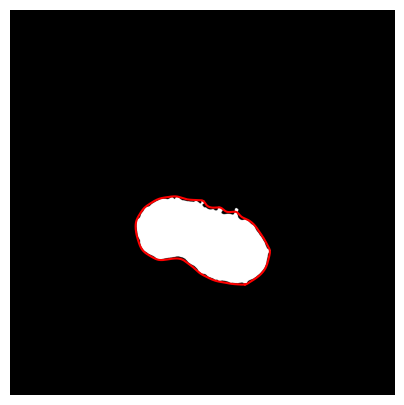

In [50]:
import matplotlib.pyplot as plt
from skimage import io, morphology
from src.analysis import medialaxis

# Load your image
image = io.imread("/Users/ericayliu/Bowling Lab/out/250623_gastruloids_MMC_250702_WT_rowD_120h_005_ch00.tiff")
# image = io.imread("/Users/ericayliu/Bowling Lab/250623_gastruloids_MMC/120h/250623_gastruloids_MMC_250702_WT_rowA_120h_001_ch00.tif")
# image = io.imread("/Users/ericayliu/Bowling Lab/250428_gastruloids_mCherry_puro_250507_120h_004_ch00.tiff")
# image = io.imread("/Users/ericayliu/Bowling Lab/250428_gastruloids_mCherry_puro_250507_120h_021_ch00.tiff")
# image = io.imread("/Users/ericayliu/Bowling Lab/250428_gastruloids_mCherry_puro_250507_120h_006_ch00.tiff")
# image = io.imread("/Users/ericayliu/Bowling Lab/091624_gastruloids_092524_120h_hm_a005_ch00 (2).tif")

lbl = imu.binarize(image)
mask = imu.clean_binarized(lbl)
mask_arg = np.argwhere(mask).T
mask_cnt = imuj.bw_to_snake(mask)

# BBOX
BBOX = [np.min(mask_arg[0]) - 100, np.max(mask_arg[0]) + 100, np.min(mask_arg[1]) - 100,
        np.max(mask_arg[1]) + 100]

cnt = imu.get_contour(mask, image, alpha=0.05, beta=0.5, w_line=0, w_edge=0)
cnt = np.asarray(cnt[0])

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow( image, cmap='gray')
xC,yC = cnt.T
axs.plot(yC, xC, c='r')
axs.axis('off')

In [52]:
# cnt = contours[0]
MedialAxis, length = ma.get_axis_and_length( cnt, image)

um_per_pixel = 0.5 # from Pasteur Lab

print("Length = ", str(length*um_per_pixel), 'µm' )

Length =  383.3013512474721 µm


(-0.5, 2047.5, 2047.5, -0.5)

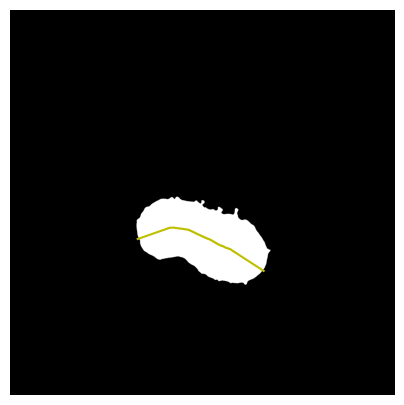

In [53]:
 fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow( image, cmap='gray')
xM,yM = MedialAxis.T
axs.plot(yM, xM, c='y')
axs.axis('off')

In [54]:
import cv2
import numpy as np

# Convert the contour to a numpy array of type np.int32
cnt = np.array(cnt, dtype=np.int32)

# Compute area using OpenCV
area = cv2.contourArea(cnt)

um_per_pixel = 0.5  # Pasteur Lab
physical_area = area * (um_per_pixel ** 2)
print(f"Area = {physical_area:.2f} µm²")

Area = 56657.75 µm²
